In [1]:
#TDA
import gtda.plotting
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

from mapper_utils import *
#Data wrangling
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
#ML and visualizations
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import catboost
from catboost import *
import shap
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
shap.initjs()

#### Load data and fit ML model.

* Read the red wine and white wine files, assign a variable indicating their type (0 for red and 1 for white), and concatenate them and shuffle them into a singe dataframe.
<br>
* Fit a catboost regressor on the variable 'quality' (the higher, the better the wine)

In [2]:
red_wine = pd.read_csv('winequality-red.csv', delimiter = ';')
red_wine['type'] = 0

white_wine = pd.read_csv('winequality-white.csv', delimiter = ';')
white_wine['type'] = 1

wine = pd.concat([red_wine,white_wine], axis=0).sample(frac = 1, random_state = 123).reset_index(drop=True)

X,y = wine.drop('quality',axis=1), wine['quality']

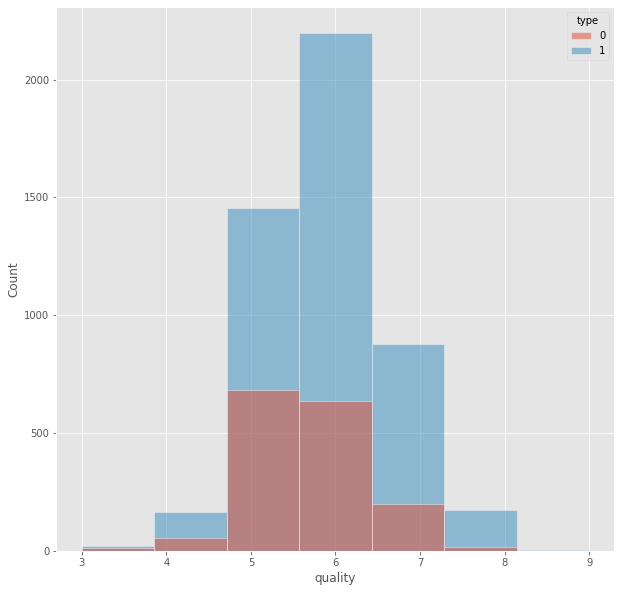

In [3]:
plt.figure(figsize=(10,10))
sns.histplot(x='quality', data = wine, hue='type', bins = 7);

In [4]:
Xtrain_aux, Xtest_aux, ytrain, ytest = train_test_split(X, y, train_size=0.75, stratify=y, random_state=123)
Xtest = Xtest_aux.drop('type',axis=1)
Xtrain = Xtrain_aux.drop('type',axis=1)

In [5]:
train_pool = Pool(data = Xtrain, 
                  label = ytrain)
                  #cat_features=['type'])
test_pool = Pool(data = Xtest,
                 label = ytest)
                 #cat_features=['type']) 

params = {'loss_function': 'RMSE',
          'iterations': 1000,
          'eval_metric': 'MAPE',
          'random_seed':123
         }


results = cv(params = params,
             early_stopping_rounds = 50,
             pool = train_pool,
             fold_count = 3,
             shuffle = True,
             partition_random_seed = 123,
             plot = True,
             verbose = False,
             stratified = True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [6]:
best_iterations = list(results[results['test-MAPE-mean'] == results['test-MAPE-mean'].min()]\
                       ['iterations']).pop()

results[results['test-MAPE-mean'] == results['test-MAPE-mean'].min()]

iterations  test-MAPE-mean  test-MAPE-std  train-MAPE-mean  \
999         999        0.090147       0.000946         0.066202   

     train-MAPE-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
999        0.001975        0.659358         0.0119         0.483513   

     train-RMSE-std  
999        0.014354

In [7]:
model = CatBoostRegressor(iterations = best_iterations+1, 
                          loss_function = 'RMSE',
                          verbose = False,
                          random_seed = 123)

model.fit(train_pool, verbose = False)

predictions = model.predict(Xtest)

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], Xtest.iloc[0,:])

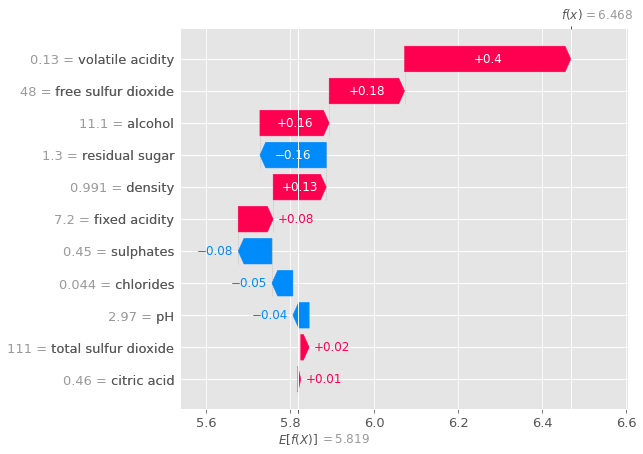

In [9]:
shap.plots.waterfall(explainer(Xtest)[0], max_display = 12)

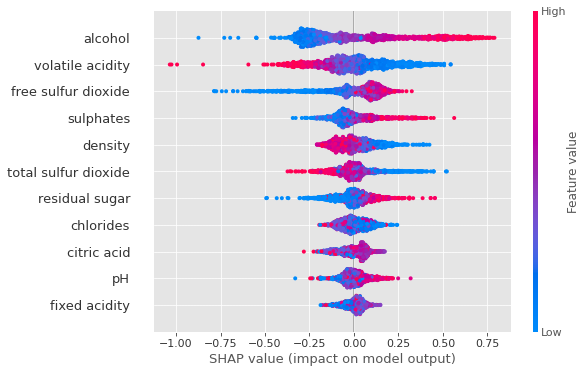

In [10]:
shap.summary_plot(shap_values, Xtest)

In [77]:
shap.force_plot(explainer.expected_value, shap_values, Xtest)

#### Concatenate the SHAP matrix, the data matrix X, and the labels, predictions and Absolute Percentage Error in a single dataframe Xshap.

In [12]:
shap_df = pd.DataFrame(shap_values, 
                       columns = [col + '_shap' for col in Xtest.columns], 
                       index = Xtest.index)

In [13]:
y_hat = pd.Series(predictions,
                  name='predictions',
                  index = ytest.index)

shap_info = pd.concat([shap_df,ytest, y_hat], axis=1)

In [14]:
shap_info

fixed acidity_shap  volatile acidity_shap  citric acid_shap  \
4994            0.083152               0.395683          0.006860   
1180            0.037835               0.110793          0.061688   
6395            0.023284              -0.036980         -0.027655   
420             0.001765              -0.020447          0.035082   
285            -0.130496              -0.226877         -0.135523   
...                  ...                    ...               ...   
3853            0.004834               0.032812         -0.015062   
3427            0.059449              -0.093413         -0.227156   
1802            0.016622              -0.049244          0.051900   
6059           -0.009230               0.306098          0.021794   
5291            0.016911              -0.358288         -0.101757   

      residual sugar_shap  chlorides_shap  free sulfur dioxide_shap  \
4994            -0.157781       -0.049845                  0.179330   
1180            -0.004082        0.011489                  0.204045   
6395             0.063837       -0.015582                 -0.030795   
420              0.107375       -0.003873                  0.069873   
285             -0.039240       -0.010160                 -0.080248   
...                   ...             ...                       ...   
3853            -0.116390       -0.016783                 -0.582762   
3427             0.083342        0.019323                  0.087509   
1802            -0.070678       -0.032108                 -0.082936   
6059            -0.110958       -0.101853                 -0.076802   
5291            -0.147806       -0.038348                 -0.001925   

      total sulfur dioxide_shap  density_shap   pH_shap  sulphates_shap  \
4994                   0.019867      0.126314 -0.038668       -0.080251   
1180                  -0.202964      0.122353  0.080791        0.005212   
6395                   0.128101      0.015657  0.035263        0.258200   
420                   -0.002109      0.110611 -0.023180       -0.016034   
285                    0.055162     -0.178626  0.016006       -0.063183   
...                         ...           ...       ...             ...   
3853                  -0.187430      0.004644 -0.044284        0.153164   
3427                  -0.028775     -0.191523 -0.057383       -0.079465   
1802                   0.001877      0.002421  0.052644       -0.057426   
6059                  -0.032833     -0.004826 -0.024796       -0.077125   
5291                  -0.008890      0.062558 -0.061402       -0.079247   

      alcohol_shap  quality  predictions  
4994      0.164740        5     6.468326  
1180      0.454207        6     6.700292  
6395      0.684787        7     6.917042  
420       0.630525        6     6.708514  
285      -0.328459        6     4.697283  
...            ...      ...          ...  
3853      0.123351        6     5.175019  
3427     -0.303145        5     5.087688  
1802     -0.280133        6     5.371864  
6059     -0.200987        7     5.507408  
5291     -0.131862        4     4.968870  

[1625 rows x 13 columns]

In [15]:
Xshap = pd.concat([Xtest_aux,shap_info],axis=1)
Xshap['AbsolutePercentageError'] = np.abs(shap_info['quality']-shap_info['predictions'])/shap_info['quality']

In [16]:
Xshap

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4994            7.2              0.13         0.46             1.3      0.044   
1180            7.1              0.21         0.35             2.5      0.040   
6395            8.7              0.41         0.41             6.2      0.078   
420             6.4              0.30         0.27             5.0      0.058   
285            13.2              0.46         0.52             2.2      0.071   
...             ...               ...          ...             ...        ...   
3853            6.9              0.27         0.41             1.7      0.047   
3427            7.3              0.30         0.74            13.5      0.039   
1802            6.3              0.30         0.34             1.6      0.049   
6059            8.0              0.19         0.36             1.8      0.050   
5291            6.8              0.63         0.04             1.3      0.058   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4994                 48.0                 111.0  0.99127  2.97       0.45   
1180                 41.0                 186.0  0.99128  3.32       0.56   
6395                 25.0                  42.0  0.99530  3.24       0.77   
420                  27.0                 151.0  0.99198  3.22       0.49   
285                  12.0                  35.0  1.00060  3.10       0.56   
...                   ...                   ...      ...   ...        ...   
3853                  6.0                 134.0  0.99290  3.15       0.69   
3427                 46.0                 165.0  0.99820  3.02       0.40   
1802                 14.0                 132.0  0.99400  3.30       0.49   
6059                 16.0                  84.0  0.99360  3.15       0.45   
5291                 25.0                 133.0  0.99271  3.17       0.39   

      ...  chlorides_shap  free sulfur dioxide_shap  \
4994  ...       -0.049845                  0.179330   
1180  ...        0.011489                  0.204045   
6395  ...       -0.015582                 -0.030795   
420   ...       -0.003873                  0.069873   
285   ...       -0.010160                 -0.080248   
...   ...             ...                       ...   
3853  ...       -0.016783                 -0.582762   
3427  ...        0.019323                  0.087509   
1802  ...       -0.032108                 -0.082936   
6059  ...       -0.101853                 -0.076802   
5291  ...       -0.038348                 -0.001925   

      total sulfur dioxide_shap  density_shap   pH_shap  sulphates_shap  \
4994                   0.019867      0.126314 -0.038668       -0.080251   
1180                  -0.202964      0.122353  0.080791        0.005212   
6395                   0.128101      0.015657  0.035263        0.258200   
420                   -0.002109      0.110611 -0.023180       -0.016034   
285                    0.055162     -0.178626  0.016006       -0.063183   
...                         ...           ...       ...             ...   
3853                  -0.187430      0.004644 -0.044284        0.153164   
3427                  -0.028775     -0.191523 -0.057383       -0.079465   
1802                   0.001877      0.002421  0.052644       -0.057426   
6059                  -0.032833     -0.004826 -0.024796       -0.077125   
5291                  -0.008890      0.062558 -0.061402       -0.079247   

      alcohol_shap  quality  predictions  AbsolutePercentageError  
4994      0.164740        5     6.468326                 0.293665  
1180      0.454207        6     6.700292                 0.116715  
6395      0.684787        7     6.917042                 0.011851  
420       0.630525        6     6.708514                 0.118086  
285      -0.328459        6     4.697283                 0.217120  
...            ...      ...          ...                      ...  
3853      0.123351        6     5.175019                 0.137497  
34

In [17]:
column_of_interest = 'quality'
lense = PCA(n_components = 1)
h_fn = 'variance'
to_drop = [col for col in Xshap.columns if '_shap' in col] + ['type','predictions','AbsolutePercentageError']
study = optimize_mapper(X = Xshap.drop(to_drop,axis=1), 
                        label = column_of_interest, 
                        lense = lense,
                        h_fn = h_fn,
                        n_trials = 250,
                        timeout = None,
                        random_state = 1)

[I 2021-08-19 18:24:56,212] A new study created in memory with name: no-name-52f37048-4885-429b-9621-210f90461d4b


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:24:56,765] Trial 0 finished with values: [71.16666666666667, 0.4541429321457142] and parameters: {'n_intervals': 27, 'overlap_frac': 0.3741460220489711, 'eps': 0.002143633798631522, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:24:57,223] Trial 1 finished with values: [24.704225352112676, 0.45924884785159076] and parameters: {'n_intervals': 16, 'overlap_frac': 0.091552367645959, 'eps': 1.8634158535653313, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:24:57,819] Trial 2 finished with values: [27.166666666666668, 0.4911221451831189] and parameters: {'n_intervals': 26, 'overlap_frac': 0.2924675303015106, 'eps': 4.192525949518545, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:24:58,421] Trial 3 finished with values: [144.3, 0.5711793643469956] and parameters: {'n_intervals': 18, 'overlap_frac': 0.44515284637592545, 'eps': 0.2748485443860637, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s


[I 2021-08-19 18:24:59,543] Trial 4 finished with values: [10.71889400921659, 0.18358347293226468] and parameters: {'n_intervals': 27, 'overlap_frac': 0.3014104228005882, 'eps': 1.4047289990137424, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:25:00,458] Trial 5 finished with values: [19.67295597484277, 0.518882281820822] and parameters: {'n_intervals': 42, 'overlap_frac': 0.4857177090737289, 'eps': 3.1349283574142692, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.6s


[I 2021-08-19 18:25:01,620] Trial 6 finished with values: [13.178571428571429, 0.11804032631931441] and parameters: {'n_intervals': 45, 'overlap_frac': 0.4525729985767313, 'eps': 0.8513570694864094, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:02,153] Trial 7 finished with values: [94.9, 0.3663870729832027] and parameters: {'n_intervals': 16, 'overlap_frac': 0.4451641265432359, 'eps': 0.9843699914966679, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:02,768] Trial 8 finished with values: [22.173076923076923, 0.43059934957272133] and parameters: {'n_intervals': 49, 'overlap_frac': 0.2899243782378577, 'eps': 6.919079262390784, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:03,638] Trial 9 finished with values: [74.02631578947368, 0.605302506131675] and parameters: {'n_intervals': 38, 'overlap_frac': 0.4255815523538178, 'eps': 0.18386448516457388, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:04,084] Trial 10 finished with values: [102.61111111111111, 0.3976039006380355] and parameters: {'n_intervals': 10, 'overlap_frac': 0.12787598694754387, 'eps': 9.671985624260362, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:04,713] Trial 11 finished with values: [45.29545454545455, 0.48766952566977523] and parameters: {'n_intervals': 18, 'overlap_frac': 0.19803655285640714, 'eps': 6.152813657272585, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:05,755] Trial 12 finished with values: [30.464285714285715, 0.5201997261620429] and parameters: {'n_intervals': 19, 'overlap_frac': 0.38552539797391244, 'eps': 2.7392602654327214, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:25:07,929] Trial 13 finished with values: [25.875, 0.4342660023536222] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4960575656967942, 'eps': 4.498231705648671, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:08,983] Trial 14 finished with values: [48.30769230769231, 0.5746373515666647] and parameters: {'n_intervals': 34, 'overlap_frac': 0.36403546556628974, 'eps': 2.282831350780145, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:09,558] Trial 15 finished with values: [39.07692307692308, 0.31867030537911833] and parameters: {'n_intervals': 23, 'overlap_frac': 0.21435000054927825, 'eps': 8.771101205859178, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:25:10,449] Trial 16 finished with values: [22.639344262295083, 0.500728824908736] and parameters: {'n_intervals': 33, 'overlap_frac': 0.4201948715094236, 'eps': 3.7097577711271907, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:11,027] Trial 17 finished with values: [33.93055555555556, 0.5004296367893786] and parameters: {'n_intervals': 21, 'overlap_frac': 0.3371176863194463, 'eps': 5.5765655412236494, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:11,475] Trial 18 finished with values: [150.35714285714286, 0.6228174253087682] and parameters: {'n_intervals': 14, 'overlap_frac': 0.23938557298021107, 'eps': 1.143050828147865, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:12,098] Trial 19 finished with values: [77.1891891891892, 0.34701429210366047] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4524105521567241, 'eps': 6.96062850464448, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:12,683] Trial 20 finished with values: [77.28571428571429, 0.3916781766989219] and parameters: {'n_intervals': 23, 'overlap_frac': 0.4156395977857255, 'eps': 0.7752508630894832, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:13,075] Trial 21 finished with values: [91.73684210526316, 0.43895207645921014] and parameters: {'n_intervals': 10, 'overlap_frac': 0.06421657556168472, 'eps': 9.418961686356122, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:13,519] Trial 22 finished with values: [57.121212121212125, 0.47216851058352005] and parameters: {'n_intervals': 16, 'overlap_frac': 0.15069289749944914, 'eps': 7.986770126201931, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:13,994] Trial 23 finished with values: [37.54, 0.4577329489637384] and parameters: {'n_intervals': 32, 'overlap_frac': 0.13509930633673872, 'eps': 9.923494426747977, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:14,425] Trial 24 finished with values: [67.92857142857143, 0.584640061866121] and parameters: {'n_intervals': 10, 'overlap_frac': 0.16029125965101, 'eps': 1.9222007638947889, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:14,928] Trial 25 finished with values: [74.6896551724138, 0.432001887098729] and parameters: {'n_intervals': 14, 'overlap_frac': 0.2598919040057101, 'eps': 7.997194756481976, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:15,576] Trial 26 finished with values: [23.633663366336634, 0.5159740320647266] and parameters: {'n_intervals': 19, 'overlap_frac': 0.3382832134568064, 'eps': 3.217416101943702, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:16,023] Trial 27 finished with values: [33.370370370370374, 0.6003222225715577] and parameters: {'n_intervals': 23, 'overlap_frac': 0.10641053410202543, 'eps': 5.039107892007309, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:16,502] Trial 28 finished with values: [65.03225806451613, 0.565822139433284] and parameters: {'n_intervals': 30, 'overlap_frac': 0.19198903310465848, 'eps': 0.44818305884573195, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s


[I 2021-08-19 18:25:17,579] Trial 29 finished with values: [11.37914691943128, 0.1341446827981916] and parameters: {'n_intervals': 37, 'overlap_frac': 0.32560367488863934, 'eps': 1.2081848245157265, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:18,154] Trial 30 finished with values: [64.85, 0.4592874388978874] and parameters: {'n_intervals': 29, 'overlap_frac': 0.3841494223898486, 'eps': 0.03046890936503044, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:18,814] Trial 31 finished with values: [54.351851851851855, 0.32272267281017925] and parameters: {'n_intervals': 23, 'overlap_frac': 0.4597375839492167, 'eps': 8.901553602048413, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:19,440] Trial 32 finished with values: [76.21052631578948, 0.3750979002783744] and parameters: {'n_intervals': 16, 'overlap_frac': 0.45732119121163967, 'eps': 8.552664544548012, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:25:20,213] Trial 33 finished with values: [9.165775401069519, 0.2398723621360218] and parameters: {'n_intervals': 13, 'overlap_frac': 0.051380443087383584, 'eps': 1.7573441006546522, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:20,967] Trial 34 finished with values: [99.4, 0.4580489184847824] and parameters: {'n_intervals': 17, 'overlap_frac': 0.47152790757377416, 'eps': 9.521357694069728, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:25:21,868] Trial 35 finished with values: [18.45985401459854, 0.41159734974198875] and parameters: {'n_intervals': 21, 'overlap_frac': 0.36507451484038567, 'eps': 2.3348921828024682, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:25:22,874] Trial 36 finished with values: [15.01123595505618, 0.0699403479879439] and parameters: {'n_intervals': 21, 'overlap_frac': 0.40060357402478186, 'eps': 0.6577493550446564, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:23,361] Trial 37 finished with values: [69.93548387096774, 0.5571166767316413] and parameters: {'n_intervals': 26, 'overlap_frac': 0.2555762351580419, 'eps': 1.4619287901015512, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:24,001] Trial 38 finished with values: [66.34285714285714, 0.3573100434993332] and parameters: {'n_intervals': 12, 'overlap_frac': 0.31918647629448726, 'eps': 7.497468370032452, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:24,658] Trial 39 finished with values: [92.54838709677419, 0.3923464252739357] and parameters: {'n_intervals': 15, 'overlap_frac': 0.4448954502457658, 'eps': 8.74234227663707, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:25,436] Trial 40 finished with values: [87.88461538461539, 0.6146720248807135] and parameters: {'n_intervals': 26, 'overlap_frac': 0.2936791497447363, 'eps': 0.04526697921578951, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:25,934] Trial 41 finished with values: [67.44444444444444, 0.3835660392354473] and parameters: {'n_intervals': 11, 'overlap_frac': 0.11129420530542027, 'eps': 6.955660821007991, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:26,725] Trial 42 finished with values: [27.9126213592233, 0.5153786016605615] and parameters: {'n_intervals': 50, 'overlap_frac': 0.44059825982415546, 'eps': 6.577343074606066, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:27,386] Trial 43 finished with values: [94.8125, 0.41250431442957247] and parameters: {'n_intervals': 18, 'overlap_frac': 0.4758021706055431, 'eps': 9.973296844066834, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:27,987] Trial 44 finished with values: [27.971830985915492, 0.41359434847998794] and parameters: {'n_intervals': 45, 'overlap_frac': 0.17627801789790812, 'eps': 9.449133495995262, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:28,443] Trial 45 finished with values: [158.84615384615384, 0.5884279190230357] and parameters: {'n_intervals': 12, 'overlap_frac': 0.22702417844317047, 'eps': 0.5943821083216247, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.1s


[I 2021-08-19 18:25:29,983] Trial 46 finished with values: [6.670886075949367, 0.32816648362899853] and parameters: {'n_intervals': 13, 'overlap_frac': 0.23461660058829314, 'eps': 2.9715915849313643, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:30,508] Trial 47 finished with values: [18.86, 0.46337849500305234] and parameters: {'n_intervals': 15, 'overlap_frac': 0.12805986645249523, 'eps': 3.805268737988179, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:30,969] Trial 48 finished with values: [53.578947368421055, 0.6185048269683189] and parameters: {'n_intervals': 19, 'overlap_frac': 0.21580906565580515, 'eps': 2.396015759201154, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:31,610] Trial 49 finished with values: [105.96551724137932, 0.34011101651528125] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4923737228934261, 'eps': 8.990149649762081, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:32,451] Trial 50 finished with values: [29.785046728971963, 0.35767516208816635] and parameters: {'n_intervals': 46, 'overlap_frac': 0.4946339249367587, 'eps': 8.267228572964987, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:33,174] Trial 51 finished with values: [36.78313253012048, 0.3495735366613199] and parameters: {'n_intervals': 39, 'overlap_frac': 0.4746596347884991, 'eps': 9.089791169778447, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:33,907] Trial 52 finished with values: [53.42, 0.34976492098003786] and parameters: {'n_intervals': 22, 'overlap_frac': 0.3976393993558932, 'eps': 8.907125275829422, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:34,585] Trial 53 finished with values: [51.610169491525426, 0.27881325197813867] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4859599737832505, 'eps': 7.3671463040215945, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:35,254] Trial 54 finished with values: [69.06666666666666, 0.30439290798850016] and parameters: {'n_intervals': 12, 'overlap_frac': 0.49872184440015, 'eps': 7.456320318759194, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:35,977] Trial 55 finished with values: [69.06666666666666, 0.2906653806461569] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4984175471080975, 'eps': 7.607699473770325, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:37,058] Trial 56 finished with values: [49.57377049180328, 0.42756297419115247] and parameters: {'n_intervals': 14, 'overlap_frac': 0.4851671118015019, 'eps': 5.9184111378618445, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:37,748] Trial 57 finished with values: [69.82051282051282, 0.3154856057171669] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4264347789820391, 'eps': 7.538176774095951, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:38,385] Trial 58 finished with values: [74.11111111111111, 0.3062078020220803] and parameters: {'n_intervals': 12, 'overlap_frac': 0.41147648411270665, 'eps': 8.355625513501264, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:39,226] Trial 59 finished with values: [34.01190476190476, 0.3522247083016607] and parameters: {'n_intervals': 42, 'overlap_frac': 0.43634314841310756, 'eps': 9.225455894903668, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:40,066] Trial 60 finished with values: [55.471698113207545, 0.3260590698818064] and parameters: {'n_intervals': 17, 'overlap_frac': 0.46156782284655334, 'eps': 7.881229212549181, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:41,155] Trial 61 finished with values: [72.21621621621621, 0.3093611635426676] and parameters: {'n_intervals': 12, 'overlap_frac': 0.41206235544123626, 'eps': 8.26466040694903, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s


[I 2021-08-19 18:25:42,994] Trial 62 finished with values: [18.773006134969325, 0.3512650878394205] and parameters: {'n_intervals': 15, 'overlap_frac': 0.4832860665938224, 'eps': 4.948947850919289, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:44,208] Trial 63 finished with values: [91.34375, 0.3340646554142276] and parameters: {'n_intervals': 11, 'overlap_frac': 0.46755337874188757, 'eps': 8.360479568355355, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.7s


[I 2021-08-19 18:25:45,709] Trial 64 finished with values: [15.742424242424242, 0.04144290984364644] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4986125501447962, 'eps': 0.7549467789341859, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:46,517] Trial 65 finished with values: [99.06451612903226, 0.36027227557491237] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4897777436231021, 'eps': 9.215107751204243, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:47,185] Trial 66 finished with values: [49.03389830508475, 0.4491430271530254] and parameters: {'n_intervals': 37, 'overlap_frac': 0.4381021880705782, 'eps': 9.796221158194566, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:25:48,034] Trial 67 finished with values: [28.017391304347825, 0.43888953870189823] and parameters: {'n_intervals': 47, 'overlap_frac': 0.4996258358096555, 'eps': 6.638855152886857, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:48,434] Trial 68 finished with values: [73.83333333333333, 0.3731381001377388] and parameters: {'n_intervals': 10, 'overlap_frac': 0.08268452742190713, 'eps': 8.528543844515568, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:49,200] Trial 69 finished with values: [28.047619047619047, 0.34351249470395556] and parameters: {'n_intervals': 42, 'overlap_frac': 0.45224544124636035, 'eps': 7.869572859730562, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:49,765] Trial 70 finished with values: [33.83582089552239, 0.4610483511502842] and parameters: {'n_intervals': 35, 'overlap_frac': 0.2750848561149394, 'eps': 7.22663575171753, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:50,345] Trial 71 finished with values: [139.14285714285714, 0.33896500773064736] and parameters: {'n_intervals': 11, 'overlap_frac': 0.46731679356290945, 'eps': 0.46138666117778043, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:50,927] Trial 72 finished with values: [139.57142857142858, 0.33852866157619715] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4702287052713687, 'eps': 0.44319409711427565, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:51,484] Trial 73 finished with values: [109.16, 0.36030518477740786] and parameters: {'n_intervals': 14, 'overlap_frac': 0.42780586838522006, 'eps': 0.9002901026028849, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:52,072] Trial 74 finished with values: [134.9090909090909, 0.32205361638868185] and parameters: {'n_intervals': 11, 'overlap_frac': 0.47513360647872394, 'eps': 0.379663271522921, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:52,661] Trial 75 finished with values: [141.42857142857142, 0.3097650313418449] and parameters: {'n_intervals': 10, 'overlap_frac': 0.478195867644136, 'eps': 0.35590711421776317, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:53,133] Trial 76 finished with values: [41.75, 0.31072672993256534] and parameters: {'n_intervals': 10, 'overlap_frac': 0.20194190546851026, 'eps': 1.6026234614615777, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:53,758] Trial 77 finished with values: [84.02777777777777, 0.3546970132294691] and parameters: {'n_intervals': 17, 'overlap_frac': 0.4799748627167857, 'eps': 1.1939718066065161, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:54,223] Trial 78 finished with values: [93.30434782608695, 0.362693359117988] and parameters: {'n_intervals': 13, 'overlap_frac': 0.2475368949793306, 'eps': 0.3434740771533536, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:54,681] Trial 79 finished with values: [83.92, 0.37074088234131236] and parameters: {'n_intervals': 15, 'overlap_frac': 0.2233770423851721, 'eps': 0.812800641359942, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:55,181] Trial 80 finished with values: [198.45454545454547, 0.5590479723606707] and parameters: {'n_intervals': 10, 'overlap_frac': 0.2742809132871108, 'eps': 1.115311024635743, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:55,742] Trial 81 finished with values: [42.490566037735846, 0.5197943013637609] and parameters: {'n_intervals': 11, 'overlap_frac': 0.28824453454943266, 'eps': 4.432123636600222, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:56,565] Trial 82 finished with values: [25.541176470588237, 0.4795115645080775] and parameters: {'n_intervals': 10, 'overlap_frac': 0.26650328268597956, 'eps': 3.479143796222287, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:57,695] Trial 83 finished with values: [29.974683544303797, 0.5604028255849944] and parameters: {'n_intervals': 40, 'overlap_frac': 0.3222456484214392, 'eps': 5.405601227529106, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:25:58,831] Trial 84 finished with values: [61.945945945945944, 0.6190893699707598] and parameters: {'n_intervals': 12, 'overlap_frac': 0.3053736028933515, 'eps': 1.9847965310911533, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:25:59,571] Trial 85 finished with values: [32.333333333333336, 0.5010786432707359] and parameters: {'n_intervals': 11, 'overlap_frac': 0.28035793850933644, 'eps': 2.657160200835728, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:26:00,985] Trial 86 finished with values: [24.009615384615383, 0.5355391935983204] and parameters: {'n_intervals': 32, 'overlap_frac': 0.3529195707427286, 'eps': 3.9634779902665276, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:01,740] Trial 87 finished with values: [37.142857142857146, 0.5593750179023677] and parameters: {'n_intervals': 28, 'overlap_frac': 0.3015189401399744, 'eps': 6.131791619460306, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:02,254] Trial 88 finished with values: [154.06666666666666, 0.5787308837155802] and parameters: {'n_intervals': 14, 'overlap_frac': 0.31121792243955076, 'eps': 0.5303796626151163, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:02,815] Trial 89 finished with values: [53.56410256410256, 0.5874892074115299] and parameters: {'n_intervals': 12, 'overlap_frac': 0.23487440784516755, 'eps': 5.005959194315086, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:03,445] Trial 90 finished with values: [134.66666666666666, 0.5486434214524399] and parameters: {'n_intervals': 13, 'overlap_frac': 0.3435043232707837, 'eps': 1.421395861821868, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:04,035] Trial 91 finished with values: [180.0, 0.5689675120017544] and parameters: {'n_intervals': 11, 'overlap_frac': 0.2536357039276381, 'eps': 0.20986159546873484, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:26:05,005] Trial 92 finished with values: [14.28476821192053, 0.05481032576100321] and parameters: {'n_intervals': 10, 'overlap_frac': 0.26043654243264786, 'eps': 1.0601068601445731, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:05,578] Trial 93 finished with values: [131.8235294117647, 0.40019263023084706] and parameters: {'n_intervals': 11, 'overlap_frac': 0.28459625103084457, 'eps': 0.27570893828724385, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:06,281] Trial 94 finished with values: [146.66666666666666, 0.30778367637815307] and parameters: {'n_intervals': 10, 'overlap_frac': 0.49993946378426324, 'eps': 0.1534078364193866, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:07,422] Trial 95 finished with values: [17.273743016759777, 0.04554935768059479] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4936538830829175, 'eps': 0.05946435798623538, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:08,732] Trial 96 finished with values: [16.596774193548388, 0.08080442861190416] and parameters: {'n_intervals': 25, 'overlap_frac': 0.48418649189502244, 'eps': 0.028816139965676904, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:26:09,766] Trial 97 finished with values: [17.067039106145252, 0.04549907169156154] and parameters: {'n_intervals': 13, 'overlap_frac': 0.487544704718393, 'eps': 0.14192146494100172, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:10,448] Trial 98 finished with values: [28.4025974025974, 0.45527993532469524] and parameters: {'n_intervals': 14, 'overlap_frac': 0.2680137659228342, 'eps': 4.69370288245561, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:10,967] Trial 99 finished with values: [101.28571428571429, 0.29640524112495875] and parameters: {'n_intervals': 10, 'overlap_frac': 0.24876060328615807, 'eps': 0.7404042148393178, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:11,657] Trial 100 finished with values: [22.147368421052633, 0.41698468397564453] and parameters: {'n_intervals': 10, 'overlap_frac': 0.24159595174291307, 'eps': 2.0382943083765404, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:26:12,371] Trial 101 finished with values: [16.584615384615386, 0.06134818959521665] and parameters: {'n_intervals': 13, 'overlap_frac': 0.25023987890164107, 'eps': 0.1784894748631733, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:12,979] Trial 102 finished with values: [107.04761904761905, 0.29508815181125164] and parameters: {'n_intervals': 10, 'overlap_frac': 0.2967494773880965, 'eps': 0.1855366397674475, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:13,644] Trial 103 finished with values: [219.07142857142858, 0.5441040799024938] and parameters: {'n_intervals': 12, 'overlap_frac': 0.49076465606690994, 'eps': 0.7362439049327671, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:14,284] Trial 104 finished with values: [180.3125, 0.6244426716083461] and parameters: {'n_intervals': 16, 'overlap_frac': 0.45364789816953427, 'eps': 0.7358678176518599, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:15,140] Trial 105 finished with values: [64.46, 0.5720398665641007] and parameters: {'n_intervals': 48, 'overlap_frac': 0.4997833182620596, 'eps': 0.6826144344519178, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:15,886] Trial 106 finished with values: [68.41304347826087, 0.5776310780693522] and parameters: {'n_intervals': 44, 'overlap_frac': 0.4883363811736442, 'eps': 0.9938159421743077, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:16,543] Trial 107 finished with values: [197.46666666666667, 0.6336641700411275] and parameters: {'n_intervals': 15, 'overlap_frac': 0.4622252958959484, 'eps': 1.213869730145471, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:17,266] Trial 108 finished with values: [60.26923076923077, 0.5037000111671628] and parameters: {'n_intervals': 30, 'overlap_frac': 0.49117070240590743, 'eps': 1.7478243219032854, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:18,051] Trial 109 finished with values: [83.35135135135135, 0.5800037344540895] and parameters: {'n_intervals': 35, 'overlap_frac': 0.4779682147487594, 'eps': 0.8430327631276994, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:18,714] Trial 110 finished with values: [189.13333333333333, 0.6171252878088519] and parameters: {'n_intervals': 14, 'overlap_frac': 0.4485509040713064, 'eps': 1.3307567695728004, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:19,814] Trial 111 finished with values: [16.949720670391063, 0.04538928165142159] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4837904836657199, 'eps': 0.1615047417204708, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:20,274] Trial 112 finished with values: [91.14285714285714, 0.39435871314162313] and parameters: {'n_intervals': 13, 'overlap_frac': 0.1534423323242232, 'eps': 0.636820328647231, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s


[I 2021-08-19 18:26:21,419] Trial 113 finished with values: [14.824390243902439, 0.062124048008274056] and parameters: {'n_intervals': 16, 'overlap_frac': 0.484327037163033, 'eps': 1.0213043711042558, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:22,109] Trial 114 finished with values: [208.5, 0.54405633018792] and parameters: {'n_intervals': 12, 'overlap_frac': 0.46135078842352734, 'eps': 0.17786914025902673, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:22,748] Trial 115 finished with values: [122.16666666666667, 0.31801037194500287] and parameters: {'n_intervals': 12, 'overlap_frac': 0.46358768417001167, 'eps': 0.0027222915309749462, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:23,389] Trial 116 finished with values: [145.0, 0.30759452464130793] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4937721530376756, 'eps': 0.19453764527174272, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:26:24,400] Trial 117 finished with values: [16.972826086956523, 0.04435471697303064] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4997929219201756, 'eps': 0.18837171580079692, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:25,527] Trial 118 finished with values: [15.808510638297872, 0.039893937091086004] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4737437551428635, 'eps': 0.4903413503190541, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:26:26,346] Trial 119 finished with values: [24.636363636363637, 0.3575624982805548] and parameters: {'n_intervals': 12, 'overlap_frac': 0.47564813765928843, 'eps': 5.487313964188469, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:26,877] Trial 120 finished with values: [26.554054054054053, 0.4016020048700383] and parameters: {'n_intervals': 12, 'overlap_frac': 0.18221391023707872, 'eps': 5.827996700189366, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:27,567] Trial 121 finished with values: [144.71428571428572, 0.307965023929211] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4920180923377498, 'eps': 0.43367684698427983, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:28,111] Trial 122 finished with values: [106.52941176470588, 0.4045654224673303] and parameters: {'n_intervals': 11, 'overlap_frac': 0.10707287392891218, 'eps': 0.5416031575669265, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:28,894] Trial 123 finished with values: [110.26086956521739, 0.3907168558715991] and parameters: {'n_intervals': 14, 'overlap_frac': 0.37555791161908325, 'eps': 0.22181237409441584, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:30,071] Trial 124 finished with values: [16.344086021505376, 0.03383809919777223] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4925570879327114, 'eps': 0.46919813922369136, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:30,814] Trial 125 finished with values: [62.02040816326531, 0.329951652423452] and parameters: {'n_intervals': 10, 'overlap_frac': 0.49217978419795055, 'eps': 6.6679576497356745, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:31,588] Trial 126 finished with values: [47.41935483870968, 0.2881572474386496] and parameters: {'n_intervals': 15, 'overlap_frac': 0.458695511083704, 'eps': 1.5185093206179379, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:32,320] Trial 127 finished with values: [50.983333333333334, 0.28398259635329026] and parameters: {'n_intervals': 11, 'overlap_frac': 0.49252889657228527, 'eps': 7.122407955447882, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:32,757] Trial 128 finished with values: [91.94736842105263, 0.37248875589067554] and parameters: {'n_intervals': 10, 'overlap_frac': 0.06649741311832252, 'eps': 1.023064486082404, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:33,483] Trial 129 finished with values: [54.84313725490196, 0.28353564547234117] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4331340775490094, 'eps': 7.691696590719351, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s


[I 2021-08-19 18:26:34,833] Trial 130 finished with values: [14.475728155339805, 0.46505612535065377] and parameters: {'n_intervals': 20, 'overlap_frac': 0.4669888808862954, 'eps': 2.9782610113405266, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:35,364] Trial 131 finished with values: [62.53333333333333, 0.47561640299662794] and parameters: {'n_intervals': 24, 'overlap_frac': 0.13395172292094873, 'eps': 0.3388814589701035, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:36,057] Trial 132 finished with values: [44.05, 0.49935490882999506] and parameters: {'n_intervals': 50, 'overlap_frac': 0.39144324938605984, 'eps': 0.06216224827333862, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:36,741] Trial 133 finished with values: [153.25, 0.5651510161973434] and parameters: {'n_intervals': 11, 'overlap_frac': 0.1183778906372466, 'eps': 0.5601367032114566, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:37,538] Trial 134 finished with values: [129.75, 0.31853102314473386] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4996930430722357, 'eps': 0.26025704469698124, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:38,055] Trial 135 finished with values: [127.92857142857143, 0.5650239026131588] and parameters: {'n_intervals': 13, 'overlap_frac': 0.0936359915517479, 'eps': 0.8744557712645177, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:38,596] Trial 136 finished with values: [84.16666666666667, 0.3466265460409788] and parameters: {'n_intervals': 10, 'overlap_frac': 0.20710727579612015, 'eps': 1.196716044729095, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:39,360] Trial 137 finished with values: [145.21052631578948, 0.3560795420941057] and parameters: {'n_intervals': 11, 'overlap_frac': 0.43135719919201176, 'eps': 0.3944231245675952, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:40,101] Trial 138 finished with values: [84.33333333333333, 0.3827359250010017] and parameters: {'n_intervals': 14, 'overlap_frac': 0.4876063389066371, 'eps': 7.7140610651831985, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:40,814] Trial 139 finished with values: [146.61904761904762, 0.3079100468047826] and parameters: {'n_intervals': 10, 'overlap_frac': 0.49960156711658865, 'eps': 0.021825884095005077, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:41,654] Trial 140 finished with values: [79.9375, 0.5824316607360525] and parameters: {'n_intervals': 28, 'overlap_frac': 0.3625687032597524, 'eps': 1.3224716180373433, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:42,678] Trial 141 finished with values: [41.67142857142857, 0.4376441766790483] and parameters: {'n_intervals': 40, 'overlap_frac': 0.4462317671725885, 'eps': 8.11766982940494, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:43,440] Trial 142 finished with values: [44.51470588235294, 0.6495847373098943] and parameters: {'n_intervals': 31, 'overlap_frac': 0.4689473263670052, 'eps': 5.298894802799675, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:44,176] Trial 143 finished with values: [81.3157894736842, 0.5685429518184177] and parameters: {'n_intervals': 36, 'overlap_frac': 0.4816090309955461, 'eps': 0.7610478092607765, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:26:45,158] Trial 144 finished with values: [21.659574468085108, 0.5436706316449164] and parameters: {'n_intervals': 43, 'overlap_frac': 0.47434157705546287, 'eps': 3.5564617149097275, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:45,862] Trial 145 finished with values: [69.5952380952381, 0.5019092771580043] and parameters: {'n_intervals': 15, 'overlap_frac': 0.45653998977198423, 'eps': 6.469330248862325, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:46,462] Trial 146 finished with values: [76.83870967741936, 0.4859748835475165] and parameters: {'n_intervals': 13, 'overlap_frac': 0.3312549623045412, 'eps': 7.308096298212452, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:47,217] Trial 147 finished with values: [91.51428571428572, 0.5688355780100092] and parameters: {'n_intervals': 33, 'overlap_frac': 0.4994642781510491, 'eps': 0.95571791021061, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:26:48,014] Trial 148 finished with values: [12.08695652173913, 0.3477022353132209] and parameters: {'n_intervals': 17, 'overlap_frac': 0.16565379358551757, 'eps': 4.285910779950631, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:48,835] Trial 149 finished with values: [38.54320987654321, 0.5406142449256519] and parameters: {'n_intervals': 38, 'overlap_frac': 0.48354876232268, 'eps': 6.340015523056301, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:49,580] Trial 150 finished with values: [56.60377358490566, 0.4148923245538207] and parameters: {'n_intervals': 26, 'overlap_frac': 0.46716595565753766, 'eps': 8.624999865706945, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:50,330] Trial 151 finished with values: [55.21818181818182, 0.2811844230677483] and parameters: {'n_intervals': 13, 'overlap_frac': 0.48453273098517863, 'eps': 7.660860704147114, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:51,033] Trial 152 finished with values: [178.76470588235293, 0.5642792123536589] and parameters: {'n_intervals': 12, 'overlap_frac': 0.48489141179107487, 'eps': 1.7324704850434078, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:51,626] Trial 153 finished with values: [24.642857142857142, 0.5720435099910923] and parameters: {'n_intervals': 47, 'overlap_frac': 0.053655175168971114, 'eps': 2.1898553151930185, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:52,432] Trial 154 finished with values: [42.75342465753425, 0.534462065448584] and parameters: {'n_intervals': 22, 'overlap_frac': 0.4898187451571295, 'eps': 4.747421241856371, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:53,024] Trial 155 finished with values: [29.028985507246375, 0.518762411151448] and parameters: {'n_intervals': 13, 'overlap_frac': 0.19054448062628743, 'eps': 3.995586307070611, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:53,741] Trial 156 finished with values: [188.0, 0.5604712875829232] and parameters: {'n_intervals': 14, 'overlap_frac': 0.4824193593877348, 'eps': 0.817630324901649, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:54,475] Trial 157 finished with values: [32.31325301204819, 0.49252157947236574] and parameters: {'n_intervals': 16, 'overlap_frac': 0.4070361566249884, 'eps': 2.577367682506322, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:55,219] Trial 158 finished with values: [79.78947368421052, 0.37854034420011956] and parameters: {'n_intervals': 18, 'overlap_frac': 0.4751184336638515, 'eps': 9.63341338397893, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:26:56,084] Trial 159 finished with values: [37.78823529411765, 0.4568462293297121] and parameters: {'n_intervals': 41, 'overlap_frac': 0.49991480984134895, 'eps': 6.906069432951718, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:56,813] Trial 160 finished with values: [217.5, 0.6395913920515784] and parameters: {'n_intervals': 14, 'overlap_frac': 0.48874148034039305, 'eps': 0.6409336042516388, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:57,650] Trial 161 finished with values: [107.86206896551724, 0.608389479407823] and parameters: {'n_intervals': 29, 'overlap_frac': 0.4908374980932645, 'eps': 0.6135711514648107, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:26:58,434] Trial 162 finished with values: [213.85714285714286, 0.5431727145520473] and parameters: {'n_intervals': 12, 'overlap_frac': 0.47853295711687116, 'eps': 1.0183195022643117, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s


[I 2021-08-19 18:26:59,719] Trial 163 finished with values: [15.606217616580311, 0.03892584666418509] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4809335033062551, 'eps': 0.5692057154354404, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:27:00,953] Trial 164 finished with values: [16.613636363636363, 0.04249778153621915] and parameters: {'n_intervals': 12, 'overlap_frac': 0.46180096959078676, 'eps': 0.1942069958778836, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:27:01,968] Trial 165 finished with values: [17.25595238095238, 0.04056375174671186] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4639434544660215, 'eps': 0.09026781601888384, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:02,702] Trial 166 finished with values: [18.0188679245283, 0.5641481401731026] and parameters: {'n_intervals': 49, 'overlap_frac': 0.14902241549036607, 'eps': 3.3113378531727697, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:03,572] Trial 167 finished with values: [35.46511627906977, 0.5911658974942092] and parameters: {'n_intervals': 45, 'overlap_frac': 0.46955363499891895, 'eps': 5.865126988164419, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:04,239] Trial 168 finished with values: [93.70370370370371, 0.42201672923434974] and parameters: {'n_intervals': 11, 'overlap_frac': 0.3782310627281487, 'eps': 7.555143760853305, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:04,776] Trial 169 finished with values: [125.64285714285714, 0.5720064984573198] and parameters: {'n_intervals': 13, 'overlap_frac': 0.07770748312060344, 'eps': 1.3680274574717108, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:05,537] Trial 170 finished with values: [219.21428571428572, 0.636779090090738] and parameters: {'n_intervals': 14, 'overlap_frac': 0.49128726673000644, 'eps': 1.1252634922211724, 'min_samples': 5}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:06,194] Trial 171 finished with values: [202.41666666666666, 0.5580013734308672] and parameters: {'n_intervals': 11, 'overlap_frac': 0.35143567041022067, 'eps': 1.0391094584945326, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:06,966] Trial 172 finished with values: [234.46153846153845, 0.5511159491198401] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4914680675076524, 'eps': 0.6744549917086176, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:07,566] Trial 173 finished with values: [149.66666666666666, 0.5243430603159336] and parameters: {'n_intervals': 10, 'overlap_frac': 0.09982324236588211, 'eps': 1.2005895092098666, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:08,240] Trial 174 finished with values: [186.0, 0.5662743390890522] and parameters: {'n_intervals': 10, 'overlap_frac': 0.21928868110343744, 'eps': 0.7750326054694261, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:09,056] Trial 175 finished with values: [108.55172413793103, 0.5751956398419495] and parameters: {'n_intervals': 27, 'overlap_frac': 0.4918024612454287, 'eps': 0.9132919392735985, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:09,599] Trial 176 finished with values: [127.5, 0.5571134742465703] and parameters: {'n_intervals': 11, 'overlap_frac': 0.09546396645306984, 'eps': 1.2178917484608984, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:10,301] Trial 177 finished with values: [22.261363636363637, 0.5265277794482127] and parameters: {'n_intervals': 34, 'overlap_frac': 0.1683516130982763, 'eps': 2.8549509760602034, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:11,059] Trial 178 finished with values: [134.5909090909091, 0.44693298537532444] and parameters: {'n_intervals': 10, 'overlap_frac': 0.47540168649162645, 'eps': 1.5841279454562986, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:12,117] Trial 179 finished with values: [33.43636363636364, 0.5991706600404664] and parameters: {'n_intervals': 24, 'overlap_frac': 0.11572450098962556, 'eps': 5.153763705029909, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:13,286] Trial 180 finished with values: [58.5625, 0.567435951664909] and parameters: {'n_intervals': 31, 'overlap_frac': 0.1389890115703656, 'eps': 0.42026094523184027, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:14,561] Trial 181 finished with values: [59.333333333333336, 0.5785046093506493] and parameters: {'n_intervals': 38, 'overlap_frac': 0.29534871360391945, 'eps': 0.6833718038797427, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:15,566] Trial 182 finished with values: [59.92307692307692, 0.5950179082165866] and parameters: {'n_intervals': 20, 'overlap_frac': 0.492299227592429, 'eps': 5.649766954896229, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:16,342] Trial 183 finished with values: [248.91666666666666, 0.5396484808277399] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4830006433772161, 'eps': 0.9206208342457806, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:17,128] Trial 184 finished with values: [210.92857142857142, 0.5347393343216321] and parameters: {'n_intervals': 10, 'overlap_frac': 0.47341721462230957, 'eps': 1.259273136233894, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:17,877] Trial 185 finished with values: [173.875, 0.5244053434317748] and parameters: {'n_intervals': 10, 'overlap_frac': 0.43913859760107476, 'eps': 1.4999285858041533, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:18,626] Trial 186 finished with values: [186.06666666666666, 0.5441472891839093] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4415635849224112, 'eps': 1.4483853213996134, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:19,377] Trial 187 finished with values: [90.16666666666667, 0.5334237747097296] and parameters: {'n_intervals': 10, 'overlap_frac': 0.42254883471640914, 'eps': 1.8123785350360344, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:20,141] Trial 188 finished with values: [130.0909090909091, 0.44549481877777386] and parameters: {'n_intervals': 10, 'overlap_frac': 0.45626652802676204, 'eps': 1.5769532563898618, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:20,910] Trial 189 finished with values: [202.71428571428572, 0.5235384083217355] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4511597512828332, 'eps': 1.2243709195137633, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:21,684] Trial 190 finished with values: [177.3125, 0.5376602870279038] and parameters: {'n_intervals': 11, 'overlap_frac': 0.446903354643834, 'eps': 1.3295825425190009, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:22,465] Trial 191 finished with values: [219.15384615384616, 0.5268942883078528] and parameters: {'n_intervals': 11, 'overlap_frac': 0.44986322302772064, 'eps': 0.9242853024180704, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:23,656] Trial 192 finished with values: [236.83333333333334, 0.538107000129114] and parameters: {'n_intervals': 10, 'overlap_frac': 0.452226293904597, 'eps': 0.8635597572441034, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:25,371] Trial 193 finished with values: [219.53846153846155, 0.526664612312176] and parameters: {'n_intervals': 11, 'overlap_frac': 0.45178819900555917, 'eps': 0.9516622321780676, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:27,202] Trial 194 finished with values: [223.76923076923077, 0.5453953879205294] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4653652368779849, 'eps': 0.8619373831055238, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:28,876] Trial 195 finished with values: [81.39285714285714, 0.3761030072516456] and parameters: {'n_intervals': 10, 'overlap_frac': 0.311613272154871, 'eps': 7.670446702499044, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:30,139] Trial 196 finished with values: [88.57575757575758, 0.39432897848661896] and parameters: {'n_intervals': 11, 'overlap_frac': 0.467771820355218, 'eps': 8.07166060452721, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:30,996] Trial 197 finished with values: [229.5, 0.5415866064850825] and parameters: {'n_intervals': 10, 'overlap_frac': 0.43296023697000596, 'eps': 0.9652079320171743, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:31,820] Trial 198 finished with values: [75.71052631578948, 0.48622161534224173] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4583705448864352, 'eps': 6.093133173063693, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:32,643] Trial 199 finished with values: [68.97560975609755, 0.6484970016012824] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4497437005087551, 'eps': 4.739482083205994, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:33,520] Trial 200 finished with values: [30.23913043478261, 0.46270463110233667] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4349273740175579, 'eps': 3.812685337395851, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:34,344] Trial 201 finished with values: [248.0, 0.539989727564771] and parameters: {'n_intervals': 10, 'overlap_frac': 0.47966932399916645, 'eps': 0.9945158677814291, 'min_samples': 4}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:35,208] Trial 202 finished with values: [45.25806451612903, 0.25469341844830967] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4422309699917943, 'eps': 7.249298743621979, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:36,440] Trial 203 finished with values: [76.88888888888889, 0.30944013416506067] and parameters: {'n_intervals': 13, 'overlap_frac': 0.4271039724464152, 'eps': 9.117024938794177, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:37,847] Trial 204 finished with values: [72.5945945945946, 0.2876277407901246] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4172563460615862, 'eps': 8.789179769562717, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:39,443] Trial 205 finished with values: [72.5945945945946, 0.28769389657645555] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4171456770615439, 'eps': 8.895246757559011, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:41,234] Trial 206 finished with values: [89.4, 0.30072150357161703] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4154952526653135, 'eps': 9.988120758642797, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:42,609] Trial 207 finished with values: [85.8125, 0.3459431296005736] and parameters: {'n_intervals': 13, 'overlap_frac': 0.42267019508855935, 'eps': 9.414831504743853, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:43,524] Trial 208 finished with values: [41.26470588235294, 0.2749374893077182] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4421994372535452, 'eps': 6.7496186002442045, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:44,473] Trial 209 finished with values: [41.23529411764706, 0.2637168229569543] and parameters: {'n_intervals': 12, 'overlap_frac': 0.4417240943437111, 'eps': 6.831652667141967, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:45,388] Trial 210 finished with values: [45.87096774193548, 0.2465052267693886] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4486264096429907, 'eps': 7.0611673295241255, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:46,351] Trial 211 finished with values: [47.483333333333334, 0.26400457842826336] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4499286886567288, 'eps': 7.093211268383888, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:47,538] Trial 212 finished with values: [45.333333333333336, 0.25227191458370146] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4522368111443229, 'eps': 6.985163366858147, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:48,504] Trial 213 finished with values: [47.6, 0.26394616114409847] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4522011173780776, 'eps': 7.133014149362644, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:49,489] Trial 214 finished with values: [56.92, 0.2939053053085378] and parameters: {'n_intervals': 10, 'overlap_frac': 0.45293154048102696, 'eps': 7.3724348263978605, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:50,434] Trial 215 finished with values: [45.38095238095238, 0.25241754242526154] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4534245876514404, 'eps': 7.0174158991530575, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:51,300] Trial 216 finished with values: [45.43103448275862, 0.29376294397305347] and parameters: {'n_intervals': 10, 'overlap_frac': 0.40796751757003913, 'eps': 7.088431888461506, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:52,672] Trial 217 finished with values: [41.109375, 0.26975668263998764] and parameters: {'n_intervals': 11, 'overlap_frac': 0.40328658371771603, 'eps': 6.474286848523095, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:54,488] Trial 218 finished with values: [40.77272727272727, 0.28504346960340377] and parameters: {'n_intervals': 10, 'overlap_frac': 0.41742485122536144, 'eps': 6.893711598507639, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:27:55,988] Trial 219 finished with values: [48.301886792452834, 0.25084241938551666] and parameters: {'n_intervals': 11, 'overlap_frac': 0.3883822092475158, 'eps': 7.378978385178355, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:56,946] Trial 220 finished with values: [51.86, 0.30134558388029903] and parameters: {'n_intervals': 10, 'overlap_frac': 0.3967129802610562, 'eps': 7.389283850133595, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:57,789] Trial 221 finished with values: [47.7, 0.2878568009159699] and parameters: {'n_intervals': 10, 'overlap_frac': 0.3402524623023964, 'eps': 7.482309117226422, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:27:58,697] Trial 222 finished with values: [61.93333333333333, 0.2863906685221201] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4361046605507496, 'eps': 7.26491025802768, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:27:59,759] Trial 223 finished with values: [16.653333333333332, 0.04460451882259707] and parameters: {'n_intervals': 11, 'overlap_frac': 0.3675690184532807, 'eps': 0.01835683688124093, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:00,674] Trial 224 finished with values: [56.857142857142854, 0.2697000818630929] and parameters: {'n_intervals': 11, 'overlap_frac': 0.43594057913086004, 'eps': 7.779890325223569, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:01,596] Trial 225 finished with values: [57.06122448979592, 0.2697770159388081] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4389124527804381, 'eps': 7.85704723380125, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:02,503] Trial 226 finished with values: [54.84, 0.3854587389307206] and parameters: {'n_intervals': 10, 'overlap_frac': 0.42983862789502725, 'eps': 6.6778580373719185, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:03,742] Trial 227 finished with values: [15.335135135135134, 0.4521720062037899] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4468412781028912, 'eps': 3.2825432733370183, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:28:04,740] Trial 228 finished with values: [28.367346938775512, 0.42248424202698026] and parameters: {'n_intervals': 10, 'overlap_frac': 0.438529231131146, 'eps': 4.505700544706427, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:05,683] Trial 229 finished with values: [60.083333333333336, 0.2999331389369381] and parameters: {'n_intervals': 11, 'overlap_frac': 0.45931830442775, 'eps': 7.240050235514082, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:28:06,647] Trial 230 finished with values: [19.8135593220339, 0.3917828771125237] and parameters: {'n_intervals': 10, 'overlap_frac': 0.32829294252271735, 'eps': 2.3312826688985715, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:07,866] Trial 231 finished with values: [16.260115606936417, 0.03939888361645834] and parameters: {'n_intervals': 11, 'overlap_frac': 0.44276636834308475, 'eps': 0.2890258248568641, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:08,771] Trial 232 finished with values: [39.640625, 0.2799878502803588] and parameters: {'n_intervals': 10, 'overlap_frac': 0.38406651820236976, 'eps': 6.88048946132744, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:09,654] Trial 233 finished with values: [42.45454545454545, 0.25451895922111606] and parameters: {'n_intervals': 11, 'overlap_frac': 0.3190527891045142, 'eps': 7.01581382161455, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:10,841] Trial 234 finished with values: [17.757763975155278, 0.03893580016488619] and parameters: {'n_intervals': 10, 'overlap_frac': 0.45563760722454844, 'eps': 0.04757060153235157, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:12,036] Trial 235 finished with values: [17.987577639751553, 0.03888868463889613] and parameters: {'n_intervals': 10, 'overlap_frac': 0.46064041120297866, 'eps': 0.004181814865252292, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:28:13,180] Trial 236 finished with values: [18.091503267973856, 0.0409873483514664] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4358391571605287, 'eps': 0.010991429790752127, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:14,383] Trial 237 finished with values: [16.264705882352942, 0.03700618099753147] and parameters: {'n_intervals': 10, 'overlap_frac': 0.435379696677756, 'eps': 0.34008522967673155, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:28:15,564] Trial 238 finished with values: [18.07051282051282, 0.04015706570685412] and parameters: {'n_intervals': 10, 'overlap_frac': 0.44787109979237716, 'eps': 0.01136017602755171, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:28:16,702] Trial 239 finished with values: [20.319148936170212, 0.4117978442057781] and parameters: {'n_intervals': 12, 'overlap_frac': 0.45252603172675476, 'eps': 2.159485035904156, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:28:17,752] Trial 240 finished with values: [26.10185185185185, 0.4192219474006241] and parameters: {'n_intervals': 10, 'overlap_frac': 0.44788128756422646, 'eps': 4.1182342412876585, 'min_samples': 3}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:18,722] Trial 241 finished with values: [46.28333333333333, 0.27540125982668673] and parameters: {'n_intervals': 10, 'overlap_frac': 0.4375325207337426, 'eps': 7.236316582086912, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s


[I 2021-08-19 18:28:20,007] Trial 242 finished with values: [15.933701657458563, 0.0379291288648368] and parameters: {'n_intervals': 11, 'overlap_frac': 0.4606629332440155, 'eps': 0.47599283838782264, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:20,850] Trial 243 finished with values: [48.333333333333336, 0.29747931722180043] and parameters: {'n_intervals': 10, 'overlap_frac': 0.21135901484248792, 'eps': 7.374567221058506, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s


[I 2021-08-19 18:28:22,365] Trial 244 finished with values: [10.772972972972973, 0.1386264690829427] and parameters: {'n_intervals': 11, 'overlap_frac': 0.1927935208190633, 'eps': 1.4348053355809014, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:28:23,900] Trial 245 finished with values: [18.65648854961832, 0.04695443062556295] and parameters: {'n_intervals': 10, 'overlap_frac': 0.35816261442973596, 'eps': 0.0032043434469993803, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s


[I 2021-08-19 18:28:24,986] Trial 246 finished with values: [18.643939393939394, 0.04654401466667632] and parameters: {'n_intervals': 10, 'overlap_frac': 0.3641583884807049, 'eps': 0.013268607351862638, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:28:25,983] Trial 247 finished with values: [37.352112676056336, 0.3237865917573055] and parameters: {'n_intervals': 24, 'overlap_frac': 0.39324576354294893, 'eps': 7.880231127148437, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s


[I 2021-08-19 18:28:26,944] Trial 248 finished with values: [44.714285714285715, 0.3078576843131432] and parameters: {'n_intervals': 19, 'overlap_frac': 0.3692854925373219, 'eps': 8.14608605402054, 'min_samples': 2}. 


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


[I 2021-08-19 18:28:27,845] Trial 249 finished with values: [115.19047619047619, 0.4017225770109129] and parameters: {'n_intervals': 10, 'overlap_frac': 0.35072750474157494, 'eps': 9.808716989436991, 'min_samples': 3}. 


In [18]:
plot = optuna.visualization.plot_pareto_front(study, target_names=["Average Size", "Average Heterogeneity"])
plot

plot_pareto_front is experimental (supported from v2.4.0). The interface can change in the future.


In [59]:
selected_trial = 222
trial = [(t.params, t.values) for t in study.trials if t.number == selected_trial]
best_params = trial[0][0]
trial[0]

({'n_intervals': 11,
  'overlap_frac': 0.4361046605507496,
  'eps': 7.26491025802768,
  'min_samples': 3},
 [61.93333333333333, 0.2863906685221201])

In [63]:
cover = CubicalCover(n_intervals = best_params['n_intervals'],
                     overlap_frac = best_params['overlap_frac'])

clusterer = DBSCAN(eps = best_params['eps'], min_samples = best_params['min_samples'])
n_jobs = 1


optimized_pipe = make_mapper_pipeline(
    filter_func=lense,
    cover=cover,
    clustering_preprocessing= None,
    clusterer=clusterer,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False
)

plotly_params = {"node_trace": {"marker_colorscale":'bluered'}}



#Nice layouts are 'fr' or 'fruchterman_reingold', 'kamada-kawai' or 'kk', and 'auto'
plot_interactive_mapper_graph(optimized_pipe, 
                              Xshap.drop(to_drop,axis=1),
                              layout='kk',
                              color_data=Xshap, 
                              node_scale = 20,
                              plotly_params = plotly_params)

In [72]:
cover = CubicalCover(n_intervals = best_params['n_intervals'],
                     overlap_frac = best_params['overlap_frac'])

clusterer = DBSCAN(eps = best_params['eps'], min_samples = best_params['min_samples'])
n_jobs = 1


optimized_pipe = make_mapper_pipeline(
    filter_func=lense,
    cover=cover,
    clustering_preprocessing= None,
    clusterer=clusterer,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False
)

plotly_params = {"node_trace": {"marker_colorscale":'bluered'}}



#Nice layouts are 'fr' or 'fruchterman_reingold', 'kamada-kawai' or 'kk', and 'auto'
plot_static_mapper_graph(optimized_pipe, 
                              Xshap.drop(to_drop,axis=1),
                              layout='kk',
                              color_data=Xshap, 
                              node_scale = 15,
                              plotly_params = plotly_params)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1},
       …